## How to classify a news headlines into a revelant category.


* **Problem Statement :** BBC wants to autocategorize the news into various categories which help in recommending the right news articles to it users at a large scale.

* **Dataset source :** https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive

* Reason why using RNN of these classification is to capture the sequence of data.

In [70]:
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

In [71]:
data = pd.read_csv('/content/bbc-news-data.csv', sep='\t')
data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [72]:
# Dropping the empty subtitles

print(data.shape)
data = data[((~data['title'].isnull()) & (~data['content'].isnull()))].reset_index(drop=True)
print(data.shape)

(2225, 4)
(2225, 4)


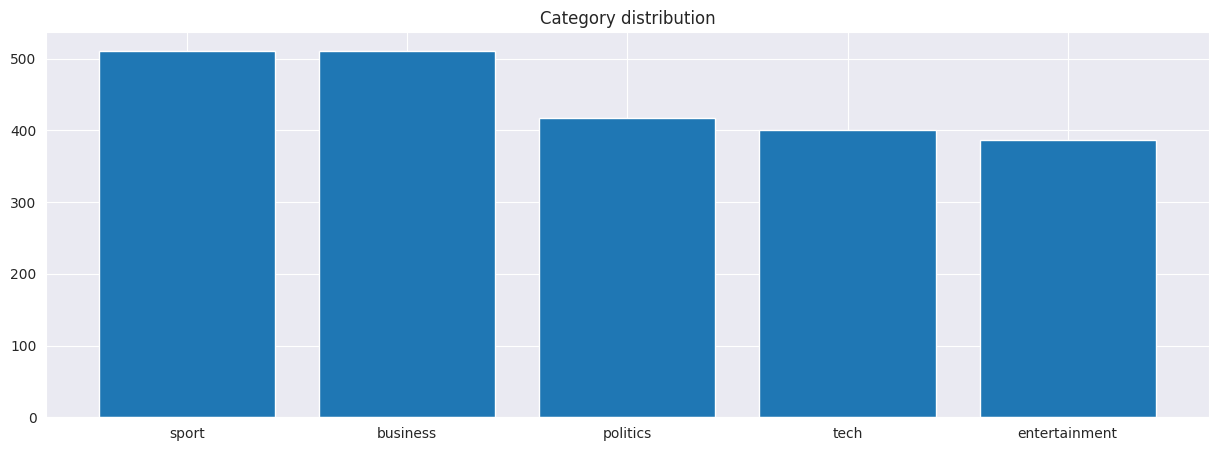

In [73]:
plt.figure(figsize=(15, 5))
plt.bar(data['category'].value_counts().index, data['category'].value_counts().values)
plt.title('Category distribution')
plt.show()

In [74]:
# lets look at one of the sample example

index = 1807
print(f'title : {data.title[index]}')
print(f'category : {data.category[index]}')

title : Federer joins all-time greats
category : sport


In [75]:
#code implementation

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, RNN, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer

import string
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split

In [76]:
# text preprocessing

def text_preprocessing(text):
  cleaned = text.lower()
  cleaned = cleaned.replace('.', '. ')
  tokenize = [word for word in cleaned.split() if word not in STOP_WORDS and word not in string.punctuation]
  cleaned = ' '.join(tokenize)
  cleaned = cleaned.strip()
  return cleaned


In [77]:
data['title'] = data['title'].apply(text_preprocessing)
data.head()

,category,filename,title,content
0,business,001.txt,ad sales boost time warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,dollar gains greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,high fuel prices hit ba's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,pernod takeover talk lifts domecq,Shares in UK drinks and food firm Allied Dome...


<Axes: ylabel='title'>

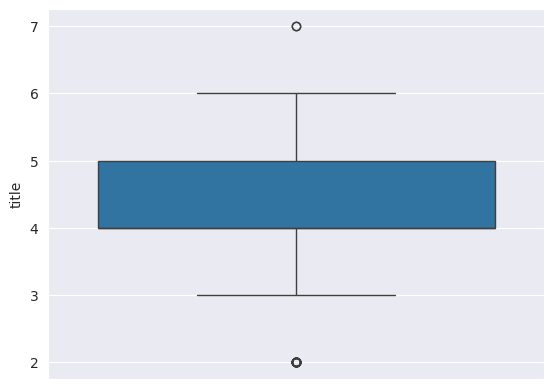

In [78]:
# Fixing the sequence length

sns.boxplot(data['title'].str.split(' ').str.len())

In [79]:
max_sequence_len = data['title'].str.split(' ').str.len().max()
min_sequence_len = data['title'].str.split(' ').str.len().min()
classes = data['category'].nunique()

print(f'Maximun length of title : {max_sequence_len}')
print(f'Minimun length of title : {min_sequence_len}')
print(f'Number of classes : {classes}')

Maximun length of title : 7
Minimun length of title : 2
Number of classes : 5


In [80]:
#Splitting the data into train and test

x_train, x_test, y_train, y_test = train_test_split(data['title'], data['category'], test_size=0.2, random_state=100)

x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [81]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1780,), (445,), (1780,), (445,))

In [82]:
# OHE the labels

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [83]:
# Tokenize the input text and Pad them

def tokenize_and_pad(input_text, max_len, token):
  text_seq = token.texts_to_sequences(input_text)
  text_seq = pad_sequences(text_seq, maxlen=max_len, padding='post')

text_token = Tokenizer()
text_token.fit_on_texts(x_train)

text_x_train = tokenize_and_pad(x_train, max_sequence_len, text_token)
text_x_test = tokenize_and_pad(x_test, max_sequence_len, text_token)

vocablory = len(text_token.word_index) + 1
print(f'Overall text vocablory : {vocablory}')

Overall text vocablory : 3487


In [84]:
# choose the latent dimension and embedding dimension

latent_dim = 50
embedding_dim = 100

In [85]:
# RNN model architucture
seed=56
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Embedding(vocablory, embedding_dim, trainable=True))
model.add(SimpleRNN(latent_dim, recurrent_dropout=0.2, return_sequences=False, activation='tanh'))
model.add(Dense(classes, activation='softmax'))
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=5)

model.fit(x=text_x_train, y=y_train, validation_data=(text_x_test, y_test), batch_size=64, epochs=10, callbacks=[early_stopping])

AttributeError: 'NoneType' object has no attribute 'shape'

SimpleRNN is ot working